# Constants

In [1]:
BORDER_REMOVAL_SIZE = .08  # Going to trim %4 of the sides
PATCH_WIDTH = 8  # Its recommended to pick patch size that can be a multiple of 8 because of the images usually a multiple of 8
PATCH_HEIGHT = PATCH_WIDTH
PERCENTAGE_OF_RANDOM_PATCHES = .20
PERCENTAGE_OF_RANDOM_PATCHES_NAME = int(PERCENTAGE_OF_RANDOM_PATCHES*100)
TEST_RANDOM_PATCH_PERCENTAGE = False



# Installs

In [2]:
%time
!pip install patchify
!pip install -U scikit-learn
!pip install swifter
!pip install seaborn
!pip install -U scikit-image
!pip install opencv-python

Wall time: 0 ns

You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


# Imports

In [3]:
%%time
import random
import os
import io
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.patches as mplpatches
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, mean_squared_log_error
from sklearn.metrics import r2_score, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage.io import imread
from scipy.interpolate import BSpline, make_interp_spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
import hashlib

import swifter

from patchify import patchify
from pathlib import Path


from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import skimage
import cv2
from skimage import color


random.seed(42)
rng = np.random.default_rng(seed=42)

Wall time: 14.4 s


# Story Arch

1. Read in the csv
2. Look at canidates
3. Compute the ITA values
4. Compute the catagory
5. Compute the metrics

# Read the CSV

In [4]:
df_csv_info = pd.read_csv("fitzpatrick17k.csv")

In [5]:
df_csv_info.head()

,Unnamed: 0,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,0,5e82a45bc5d78bd24ae9202d194423f8,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,1,fa2911a9b13b6f8af79cb700937cc14f,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,3,0a94359e7eaacd7178e06b2823777789,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,4,a39ec3b1f22c08a421fa20535e037bba,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


# Read the canidate images

In [6]:
data_list = [] # col 1 = file hash, col 2 filename, col 3, image
for file in Path(".").glob("data/canidates/*.jpg"):
    hash = hashlib.md5(open(file,'rb').read()).hexdigest()
    orig_image = open(file,"rb").read()
    data_list.append([hash, str(file), orig_image])

In [7]:
# now to create the dataframe
df = pd.DataFrame(data=data_list, columns=["hash","file_path", "image"])

In [8]:
df.head()

,hash,file_path,image
0,000b6317b3be6d504e212a50e4d5667f,data\canidates\000b6317b3be6d504e212a50e4d5667...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1,001b1edd9c7a02e9381793f6e9081d20,data\canidates\001b1edd9c7a02e9381793f6e9081d2...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...
2,001c92cc05ea5be4afa0d0e1a0dbc834,data\canidates\001c92cc05ea5be4afa0d0e1a0dbc83...,b'\xff\xd8\xff\xe1\x00\xe4Exif\x00\x00II*\x00\...
3,00a45bef0d68c8c8ca54e64e19a055ae,data\canidates\00a45bef0d68c8c8ca54e64e19a055a...,b'\xff\xd8\xff\xe1\x18nExif\x00\x00II*\x00\x08...
4,00a61ae0aa6d43a08152a7c4692ef9e2,data\canidates\00a61ae0aa6d43a08152a7c4692ef9e...,b'\xff\xd8\xff\xe1\x00\xe6Exif\x00\x00II*\x00\...


## Look at the shapes of the images.

In [9]:
shapes = {}
for item in df.iterrows():
    # print(item)
    orig_image = Image.open(io.BytesIO(item[1]["image"]))
    imgpx = np.array(orig_image)
    if str(imgpx.shape) in shapes:
        shapes[str(imgpx.shape)] += 1
    else:
        shapes[str(imgpx.shape)] = 1

In [ ]:
print(json.dumps(shapes, indent=4))

# Compute the ITA values

## Set up functions

In [11]:
def get_border_removal_size(image):
    """
    This function will compute the border removal size based on the width of the image as well as depending on the patch
    size to insure that the patches will covert the full image
    """
    w, h = image.size
    return int(math.ceil(w * BORDER_REMOVAL_SIZE / PATCH_WIDTH)) * PATCH_WIDTH

In [12]:
def trim_boarder_from_image(pil_image):
    """
    This function will take an image, remove the boarder and return the cropped image.
    """
    w, h = pil_image.size
    removal_size = get_border_removal_size(pil_image)
    cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
    cropped_image = pil_image.crop(cropped_area)
    return cropped_image

In [13]:
def format_image_and_get_patches(image):
    """
    This function will remove the 4% boarder, convert the whole image from RGB to LAB and then using Patchify
    tool it will create patches. These patches are non-overlapping that create a grid over the whole image.
    The image sizes are defined from the Constants section.
    """
    img = io.BytesIO(image)
    pil_image = Image.open(img)

    # Crop image to remove the pixels from the boarder
    w, h = pil_image.size
    removal_size = get_border_removal_size(pil_image)
    cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
    cropped_image = pil_image.crop(cropped_area)


    #print("pil_image", np.array(pil_image).shape)
    #print("cropped_image", np.array(cropped_image).shape)
    # Convert image to lab values

    lab = np.array(skimage.color.rgb2lab(cropped_image))

    # Get the patches
    return patchify(lab, (PATCH_WIDTH,PATCH_HEIGHT,3), step=PATCH_WIDTH)

In [14]:
def compute_ita_from_lab(lab):
    """
    This function computes the ITA value of the image along with ignore any pixels that are completly black
    """
    # get the luminance and b values wihtin +- 1 std from mean
    l = lab[:,:,0]
    l = np.where(l != 0, l, np.nan)
    std = np.nanstd(l)
    mean = np.nanmean(l)

    l = np.where(l >= mean - std, l, np.nan)
    l = np.where(l <= mean + std, l, np.nan)

    b = lab[:,:,2]
    std = np.nanstd(b)
    mean = np.nanmean(b)
    b = np.where(b >= mean - std, b, np.nan)
    b = np.where(b <= mean + std, b, np.nan)


    ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)
    return ita

In [15]:
def compute_ita(image, crop_border=False):
    """
    This function takes in an image and outputs the ITA value of image. To compute the ITA value the image needs
    to be converted from an RGB format to a LAB format type.

    There is an option to remove the boarder that is used to remove the back corners.
    """
    img = io.BytesIO(image)
    pilimae = Image.open(img)

    if crop_border:
        w, h = pilimae.size
        removal_size = get_border_removal_size(pilimae)
        cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
        pilimae = pilimae.crop(cropped_area)


    try:
        lab = np.array(skimage.color.rgb2lab(pilimae))
    except:
        return -1000

    return compute_ita_from_lab(lab)

## Center Cropped

In [16]:
def get_cropped_center_patches_ita_list(image, verbose=False):
    """
    For the structure patches approach the first row, the last row, first column and last column will be
    sampled for the ITA values.
    """
    """
    Note we want to ignore the center part of the images. We will take 15% around the center of the image and ignore getting the ITA
    values for those images. Taking 15% of the width and height will get offset value. Then dividing the width and height by 2
    will be the mid-point which we can take the offset and do a +- to get a range where we dont want to capture the ITA values
    as long as the x and y indexes dont fall between both ranges then we will capture the ITA values of the image.

    """
    patches = format_image_and_get_patches(image)

    center_removal_percentage = .70/2
    h = len(patches)
    w = len(patches[0])

    w_offset = math.floor(w * center_removal_percentage)
    h_offset = math.floor(h * center_removal_percentage)

    w_mid = int(w/2)
    h_mid = int(h/2)

    indices = []

    if verbose:
        print("Will ignore values in these ranges")
        print("center_removal_percentage",center_removal_percentage)
        print("w",w)
        print("h",h)
        print("w_offset",w_offset)
        print("h_offset",h_offset)
        print("w_mid",w_mid)
        print("h_mid",h_mid)
        w_range = (w_mid + w_offset) - (w_mid - w_offset)
        print(f"w range diff {w_range} : % {w_range/w}")
        h_range = (h_mid + h_offset) - (h_mid - h_offset)
        print(f"h range diff {h_range} : %{h_range/h}")
        print(f"{w_mid - w_offset} <= x < {w_mid + w_offset} and {h_mid - h_offset} <= y < {h_mid + h_offset}")
    selected_ita_values = []
    for y, y_item in enumerate(patches):
        for x, x_item in enumerate(patches[y]):
            if w_mid - w_offset <= x < w_mid + w_offset and h_mid - h_offset <= y < h_mid + h_offset:
                continue
            patch = patches[y][x][0]
            selected_ita_values.append(compute_ita_from_lab(patch))
            indices.append([y,x])

    return selected_ita_values, indices

In [17]:
def get_cropped_center_ita(row):
    """
    This is the wrapper function to calculate the ITA values for all the patches, the median ITA value and
    stores all the patch indices for each Image of the dataset.
    """
    image = row["image"]
    try:
        ita_values, indices = get_cropped_center_patches_ita_list(image)
        # dropping any nan computed values
        ita_values = [x for x in ita_values if math.isnan(x) == False]
        row["ITA_center_cropped_all"] = ita_values
        row["ITA_center_cropped"] = np.median(ita_values)
        row["ITA_center_cropped_indices"] = indices
    except:
        row["ITA_center_cropped"] = -1000

    return row

## Structured Patches

In [18]:
def get_structured_patches_ita_list(image):
    """
    For the structure patches approach the first row, the last row, first column and last column will be
    sampled for the ITA values. When taking the boarder we need ot make sure the corners are not double counted
    """
    patches = format_image_and_get_patches(image)

    selected_ita_values = []

    row_count = len(patches)
    col_count = len(patches[0])


    indices = []
    # First row
    for i, patch in enumerate(patches[0]):
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([0,i])
    # last row
    for i, patch in enumerate(patches[-1]):
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([row_count - 1,i])
    # First column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][0]
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([i,0])

    # Last column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][-1]
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([i,col_count-1])


    return selected_ita_values, indices

In [19]:
def get_structured_patches_ita(row):
    """
    This function is intended to add the ITA represented value dataframe for an instance.
    Its intended to be used with the df.swifter.apply() method
    """
    image = row["image"]
    try:
        ita_values, indices = get_structured_patches_ita_list(image)
        # dropping any nan computed values
        ita_values = [x for x in ita_values if math.isnan(x) == False]
        row["ITA_structured_patches_all"] = ita_values
        row["ITA_structured_patches"] = np.median(ita_values)
        row["ITA_structured_patches_indices"] = indices
    except:
        row["ITA_structured_patches"] = -1000

    return row

## Random Patches

In [20]:
# randomly pick numbers between 0 and max patches
def get_random_patches_ita_list(image,percentage=PERCENTAGE_OF_RANDOM_PATCHES, verbose=False):
    """
    The premise behind random patches is that a set of patches that do not overlap a generated and at random patches
    be sampled to take the ITA value from. The thought would be that because its a random sample that the majority should
    cover or represent the skin tone. It is possible that some of the patches could cover a skin lesion which will be address in
    a future approach.
    """
    patches = format_image_and_get_patches(image)
    row_count = len(patches)
    column_count = len(patches[0])

    patch_count = row_count * column_count

    random_to_select = int(patch_count * percentage)

    # Generate a random list of numbers with no duplicates
    random_patch_indexes = rng.choice(patch_count, size=random_to_select, replace=False)
    random_patch_indexes.sort()

    # get reverse indexes. The index number comes from nRow * col_count + nCol.
    # so for example if you have 10x10 image. image index 23 is row 2 col 4. The formula would be 2*10 + 4 = 24
    # x = number % column_count
    # y = int(number / column_count)

    coordinate_indices = []
    for index in random_patch_indexes:
        y = index % column_count
        x = int(index /column_count)
        coordinate_indices.append([x,y])
    if verbose:
        print(f"row_count {row_count} column_count {column_count} ")
        print(f"patch_count {patch_count}, random_to_select {random_to_select}")
        #print(f"random_patch_indexes\n{random_patch_indexes}")
        #print(f"coordinate_indices\n{coordinate_indices}")

    ita_values = []
    for index in coordinate_indices:
        x = index[1]
        y = index[0]
        patch = patches[y][x]
        ita_values.append(compute_ita_from_lab(patch[0]))
    # dropping any nan computed values
    ita_values = [x for x in ita_values if math.isnan(x) == False]
    return ita_values, coordinate_indices

In [21]:
def get_random_patches_ita(row,percentage=PERCENTAGE_OF_RANDOM_PATCHES):
    """
    This function is intended to add the ITA represented value dataframe for an instance.
    Its intended to be used with the df.swifter.apply() method
    """

    image = row["image"]
    try:
        ita_values, indices = get_random_patches_ita_list(image, percentage)
        row[f"ITA_random_patches_{int(percentage*100)}_all"] = ita_values
        row[f"ITA_random_patches_{int(percentage*100)}"] = np.median(ita_values)
        row[f"ITA_random_patches_{int(percentage*100)}_indices"] = indices
    except:
        row[f"ITA_random_patches_{int(percentage*100)}"] = -1000
    return row

## Compute ITA values on whole image

In [22]:
%%time
df["ITA_orig"] = df["image"].apply(compute_ita,crop_border=True)

Wall time: 1min 17s


In [23]:
%%time
df = df.apply(get_cropped_center_ita, axis=1)

c:\users\c0rbin\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\C0rbin\AppData\Local\Temp/ipykernel_1336/3321755401.py:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
C:\Users\C0rbin\AppData\Local\Temp/ipykernel_1336/3321755401.py:21: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


Wall time: 12min 5s


In [24]:
%%time
df = df.apply(get_structured_patches_ita, axis=1)

C:\Users\C0rbin\AppData\Local\Temp/ipykernel_1336/3321755401.py:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
C:\Users\C0rbin\AppData\Local\Temp/ipykernel_1336/3321755401.py:21: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


Wall time: 2min 33s


In [25]:
%%time
df = df.apply(get_random_patches_ita, axis=1)

C:\Users\C0rbin\AppData\Local\Temp/ipykernel_1336/3321755401.py:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
C:\Users\C0rbin\AppData\Local\Temp/ipykernel_1336/3321755401.py:21: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


Wall time: 5min 4s


In [26]:
df.head()

,hash,file_path,image,ITA_orig,ITA_center_cropped_all,ITA_center_cropped,ITA_center_cropped_indices,ITA_structured_patches_all,ITA_structured_patches,ITA_structured_patches_indices,ITA_random_patches_20_all,ITA_random_patches_20,ITA_random_patches_20_indices
0,000b6317b3be6d504e212a50e4d5667f,data\canidates\000b6317b3be6d504e212a50e4d5667...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,63.160622,"[71.3777488793279, 78.36055446746393, 72.34238...",63.902881,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[71.3777488793279, 78.36055446746393, 72.34238...",64.165841,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[70.74856447644632, 74.77155462123767, 70.0776...",63.621932,"[[0, 10], [0, 12], [0, 18], [0, 34], [0, 38], ..."
1,001b1edd9c7a02e9381793f6e9081d20,data\canidates\001b1edd9c7a02e9381793f6e9081d2...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...,17.836917,"[31.344044633930984, 27.35526223474992, 41.020...",13.918099,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[31.344044633930984, 27.35526223474992, 41.020...",13.521901,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[41.69632607411986, 39.084688843642674, 29.270...",19.593591,"[[0, 6], [0, 7], [0, 8], [0, 17], [0, 18], [0,..."
2,001c92cc05ea5be4afa0d0e1a0dbc834,data\canidates\001c92cc05ea5be4afa0d0e1a0dbc83...,b'\xff\xd8\xff\xe1\x00\xe4Exif\x00\x00II*\x00\...,19.656153,"[-9.736215619823762, -4.710450212299931, -3.44...",12.987644,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-9.736215619823762, -4.710450212299931, -3.44...",3.931059,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-4.710450212299931, -1.8890468935756766, -0.2...",20.594624,"[[0, 1], [0, 4], [0, 5], [0, 11], [0, 14], [0,..."
3,00a45bef0d68c8c8ca54e64e19a055ae,data\canidates\00a45bef0d68c8c8ca54e64e19a055a...,b'\xff\xd8\xff\xe1\x18nExif\x00\x00II*\x00\x08...,-6.305290,"[-38.95957831973621, -34.05603099911553, -31.4...",-8.752617,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-38.95957831973621, -34.05603099911553, -31.4...",-13.905133,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-38.95957831973621, -34.05603099911553, -17.8...",-5.563592,"[[0, 0], [0, 1], [0, 9], [0, 23], [0, 26], [0,..."
4,00a61ae0aa6d43a08152a7c4692ef9e2,data\canidates\00a61ae0aa6d43a08152a7c4692ef9e...,b'\xff\xd8\xff\xe1\x00\xe6Exif\x00\x00II*\x00\...,57.218695,"[-90.0, -90.93118205216486, -91.38786469212347...",45.489259,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-90.0, -90.93118205216486, -91.38786469212347...",21.325670,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-90.32930368968636, -90.07495857079323, -90.0...",57.137592,"[[0, 8], [0, 9], [0, 10], [0, 37], [0, 45], [0..."


# Compute ITA category

In [27]:
def add_ita_6_category(ita):
    if ita <= 10:
        return "6"
    elif 10 < ita <= 19:
        return "5"
    elif 19 < ita <= 28:
        return "4"
    elif 28 < ita <= 41:
        return "3"
    elif 41 < ita <= 55:
        return "2"
    elif 55 < ita:
        return "1"
    else:
        print(f"None cat: {ita}")

In [28]:
%%time
print("orig")
df["ITA_orig_category"] = df["ITA_orig"].swifter.apply(add_ita_6_category)
print("center")
df["ITA_center_cropped_category"] = df["ITA_center_cropped"].swifter.apply(add_ita_6_category)
print("struct")
df["ITA_structured_patches_category"] = df["ITA_structured_patches"].swifter.apply(add_ita_6_category)
print("rand")
df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_category"] = df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}"].swifter.apply(add_ita_6_category)

orig


Pandas Apply:   0%|          | 0/538 [00:00<?, ?it/s]

center


Pandas Apply:   0%|          | 0/538 [00:00<?, ?it/s]

struct


Pandas Apply:   0%|          | 0/538 [00:00<?, ?it/s]

rand


Pandas Apply:   0%|          | 0/538 [00:00<?, ?it/s]

Wall time: 280 ms


In [29]:
catagories_to_test = ["ITA_orig", "ITA_center_cropped", "ITA_structured_patches", "ITA_random_patches_20"]
# convert to string type
for index, cat in enumerate(catagories_to_test):
    category = f"{cat}_category"
    df[category] = df[category].astype(str)

# Evaluate ITA

In [30]:
# df_mis_match = df[df.hash != Path(df.file_path).name.strip(".jpg")]
# df_mis_match

In [65]:
df.iloc[0].file_path.split("\\")[-1].strip(".jpg")

'000b6317b3be6d504e212a50e4d5667f'

In [66]:
def add_label(row):
    """
    This function will look at the csv info and find the fitzpatrick label and apply it to the given row
    """
    hash = row.file_path.split("\\")[-1].strip(".jpg")
    row["label"] = str(df_csv_info[df_csv_info["md5hash"] == hash]["fitzpatrick"].iloc[0])
    if row["label"] == "-1":
        print(hash)
    return row

In [67]:
%%time
# add the labels to the DF
df = df.apply(add_label, axis=1)

06cc4fb3cdb76cdfe4ef9a0ae2137108
0f3b475314c6783a17c9011a9daf3559
1d1e43151f411b24f1d5886ffbb153ff
1dc929c4a7deabf67edbce72e5750311
2df39821d2328b6adee3dcacc2eb83f5
3a2bf308b3b23c153a64d1cfb46696a8
4d8c899b03bde19011e269784b4e2838
4ee002eb32ce76c88d2c2a0b825ff745
Wall time: 2.48 s


In [68]:
# Drop any row where the label was -1.
# There were some images that didnt have a classification in the csv such as 1d1e43151f411b24f1d5886ffbb153ff
df = df[df["label"] != '-1']

In [69]:
ITA_Categories_list = ["6", "5", "4", "3", "2", "1"]
ITA_Categories_list.reverse()

## View Distribution

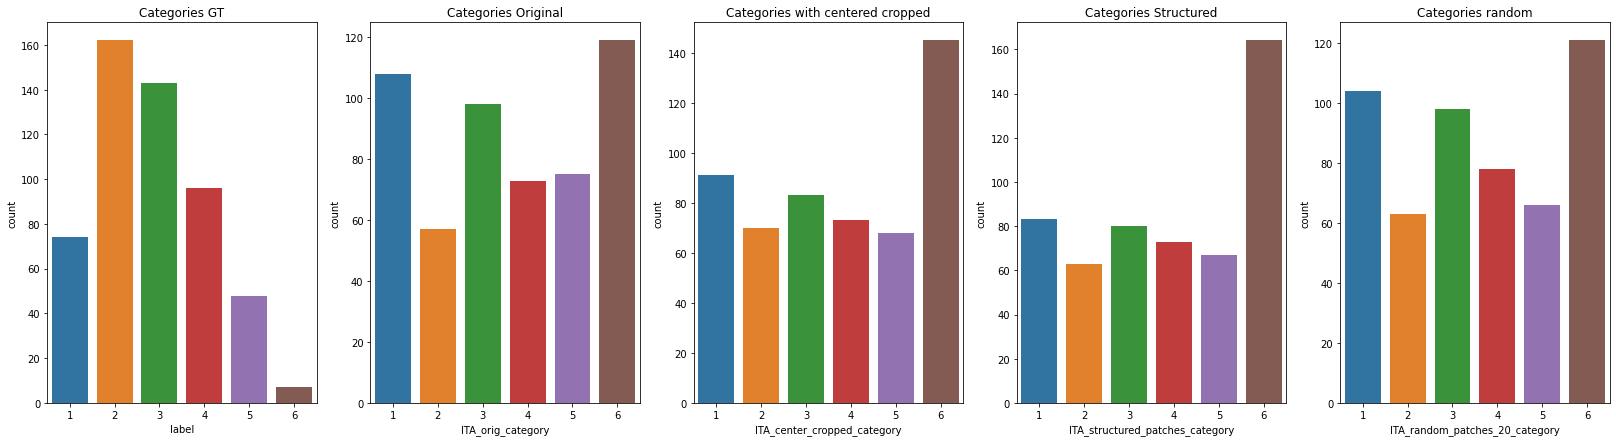

In [70]:
f, axes = plt.subplots(1, 5)
f.set_size_inches(28,7)

ax = sns.countplot(df.label,ax=axes[0],order=ITA_Categories_list).set_title("Categories GT")
ax = sns.countplot(df.ITA_orig_category,ax=axes[1],order=ITA_Categories_list).set_title("Categories Original")
ax = sns.countplot(df.ITA_center_cropped_category,ax=axes[2],order=ITA_Categories_list).set_title("Categories with centered cropped")
ax = sns.countplot(df.ITA_structured_patches_category,ax=axes[3],order=ITA_Categories_list).set_title("Categories Structured")
ax = sns.countplot(df.ITA_random_patches_20_category,ax=axes[4],order=ITA_Categories_list).set_title("Categories random")
# for i in range(0,5):
#     axes[i].set_yscale('log')

# Classification Performance

In [71]:
from sklearn import metrics
for index, cat in enumerate(catagories_to_test):

    category = f"{cat}_category"
    ground_truth = "label"

    #print(category, masked_cat)
    df_temp = df[df[category].notna()]
    df_temp = df_temp[df_temp[ground_truth].notna()]
    print(category)
    print(classification_report(df_temp[ground_truth],df_temp[category]))
    print("hamming_loss", hamming_loss(df_temp[ground_truth],df_temp[category]))
    print("---------------")

ITA_orig_category
              precision    recall  f1-score   support

           1       0.44      0.64      0.52        74
           2       0.46      0.16      0.24       162
           3       0.44      0.30      0.36       143
           4       0.21      0.16      0.18        96
           5       0.09      0.15      0.11        48
           6       0.03      0.43      0.05         7

    accuracy                           0.27       530
   macro avg       0.28      0.30      0.24       530
weighted avg       0.36      0.27      0.28       530

hamming_loss 0.7339622641509433
---------------
ITA_center_cropped_category
              precision    recall  f1-score   support

           1       0.51      0.62      0.56        74
           2       0.53      0.23      0.32       162
           3       0.42      0.24      0.31       143
           4       0.16      0.12      0.14        96
           5       0.10      0.15      0.12        48
           6       0.03      0.57     

## View Confusion matrix

<Figure size 504x504 with 0 Axes>

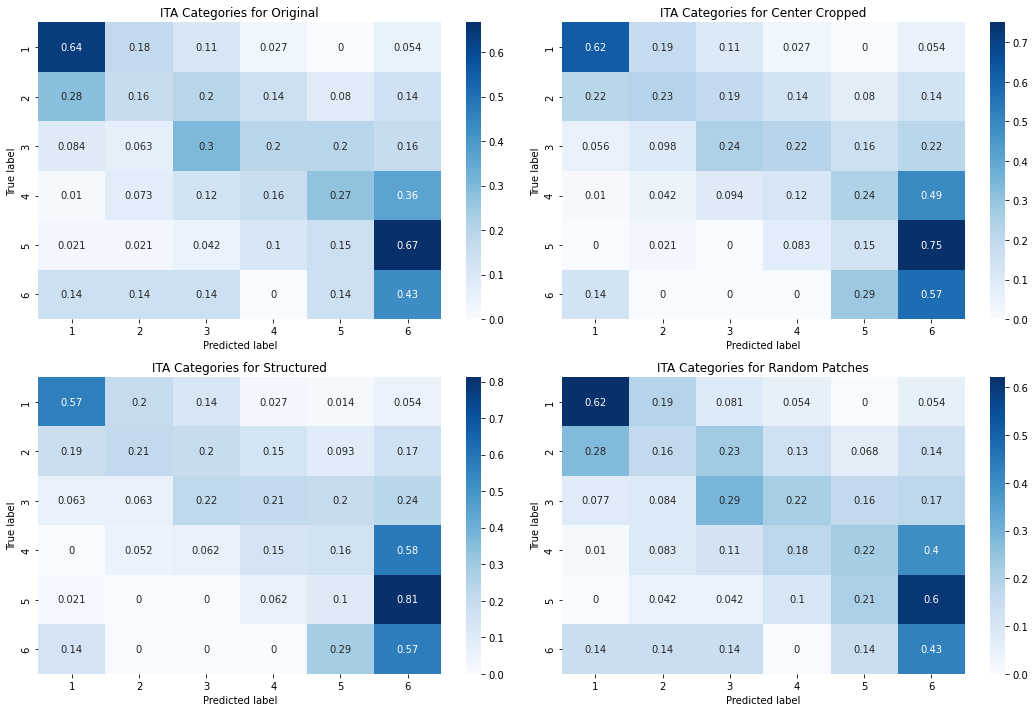

In [72]:
plt.figure(figsize=(7, 7))
cols = 2
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

plot_titles = ["ITA Categories for Original", "ITA Categories for Center Cropped", "ITA Categories for Structured", "ITA Categories for Random Patches",]

for index, cat in enumerate(catagories_to_test):

    category = f"{cat}_category"
    masked_cat = "label"

    #print(category, masked_cat)
    df_temp = df[df[category].notna()]
    df_temp = df_temp[df_temp[masked_cat].notna()]


    cm = confusion_matrix(df_temp[masked_cat],df_temp[category],normalize="true")
    df_cm = pd.DataFrame(cm,columns=np.unique(df_temp[masked_cat].to_numpy()),index=np.unique(df_temp[masked_cat].to_numpy()))
    row = index % cols
    col = int(index/cols)
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[col,row])
    ax.set_title(plot_titles[index])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
plt.tight_layout()

In [73]:
# print out ones that are not the same
# for index, cat in enumerate(catagories_to_test):
#     category = f"{cat}_category"
#     df_rez = df[df[category] != df.label]
#     for index, row in df_rez.iterrows():
#
#         if row[category] == '6' and  row.label == '2':
#             #print(row.hash, row["file_path"])
#             print(row.hash,row[category], row.label)
#     break
    #print(df[category].unique())

# Experiment by creating makes

Create skin masks using [SkinDetection.py](https://github.com/CHEREF-Mehdi/SkinDetection/blob/master/SkinDetection.py)
where we will then use that to filter out any image that doesnt have a lot of skin showing.

In [41]:
df.head()

,hash,file_path,image,ITA_orig,ITA_center_cropped_all,ITA_center_cropped,ITA_center_cropped_indices,ITA_structured_patches_all,ITA_structured_patches,ITA_structured_patches_indices,ITA_random_patches_20_all,ITA_random_patches_20,ITA_random_patches_20_indices,ITA_orig_category,ITA_center_cropped_category,ITA_structured_patches_category,ITA_random_patches_20_category,label
0,000b6317b3be6d504e212a50e4d5667f,data\canidates\000b6317b3be6d504e212a50e4d5667...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,63.160622,"[71.3777488793279, 78.36055446746393, 72.34238...",63.902881,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[71.3777488793279, 78.36055446746393, 72.34238...",64.165841,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[70.74856447644632, 74.77155462123767, 70.0776...",63.621932,"[[0, 10], [0, 12], [0, 18], [0, 34], [0, 38], ...",1,1,1,1,3
1,001b1edd9c7a02e9381793f6e9081d20,data\canidates\001b1edd9c7a02e9381793f6e9081d2...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...,17.836917,"[31.344044633930984, 27.35526223474992, 41.020...",13.918099,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[31.344044633930984, 27.35526223474992, 41.020...",13.521901,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[41.69632607411986, 39.084688843642674, 29.270...",19.593591,"[[0, 6], [0, 7], [0, 8], [0, 17], [0, 18], [0,...",5,5,5,4,3
2,001c92cc05ea5be4afa0d0e1a0dbc834,data\canidates\001c92cc05ea5be4afa0d0e1a0dbc83...,b'\xff\xd8\xff\xe1\x00\xe4Exif\x00\x00II*\x00\...,19.656153,"[-9.736215619823762, -4.710450212299931, -3.44...",12.987644,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-9.736215619823762, -4.710450212299931, -3.44...",3.931059,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-4.710450212299931, -1.8890468935756766, -0.2...",20.594624,"[[0, 1], [0, 4], [0, 5], [0, 11], [0, 14], [0,...",4,5,6,4,4
3,00a45bef0d68c8c8ca54e64e19a055ae,data\canidates\00a45bef0d68c8c8ca54e64e19a055a...,b'\xff\xd8\xff\xe1\x18nExif\x00\x00II*\x00\x08...,-6.305290,"[-38.95957831973621, -34.05603099911553, -31.4...",-8.752617,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-38.95957831973621, -34.05603099911553, -31.4...",-13.905133,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-38.95957831973621, -34.05603099911553, -17.8...",-5.563592,"[[0, 0], [0, 1], [0, 9], [0, 23], [0, 26], [0,...",6,6,6,6,4
4,00a61ae0aa6d43a08152a7c4692ef9e2,data\canidates\00a61ae0aa6d43a08152a7c4692ef9e...,b'\xff\xd8\xff\xe1\x00\xe6Exif\x00\x00II*\x00\...,57.218695,"[-90.0, -90.93118205216486, -91.38786469212347...",45.489259,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-90.0, -90.93118205216486, -91.38786469212347...",21.325670,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-90.32930368968636, -90.07495857079323, -90.0...",57.137592,"[[0, 8], [0, 9], [0, 10], [0, 37], [0, 45], [0...",1,2,4,1,2


In [42]:
"""
Steps
1. Read image
2. Create HSV mask
3. Create YCrCb mask
4. Merge masks
5. Store global mask
6. Compute % skin of image
"""

def compute_skin_masks(row):
    img = cv2.imread(row.file_path)

    #converting from gbr to hsv color space
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #skin color range for hsv color space
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17, 170, 255))
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255, 180, 135))
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask = cv2.bitwise_and(YCrCb_mask, HSV_mask)
    global_mask = cv2.medianBlur(global_mask, 3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4, 4), np.uint8))

    global_result = cv2.bitwise_not(global_mask)

    mask_array = np.array(global_result)
    total = mask_array.size
    mask_count = np.count_nonzero(mask_array)
    percentage = mask_count / total
    row["skin_detection_percentage"] = math.ceil(percentage * 100)
    return row


In [43]:
df = df.apply(compute_skin_masks, axis=1)

In [44]:
df.head()

,hash,file_path,image,ITA_orig,ITA_center_cropped_all,ITA_center_cropped,ITA_center_cropped_indices,ITA_structured_patches_all,ITA_structured_patches,ITA_structured_patches_indices,ITA_random_patches_20_all,ITA_random_patches_20,ITA_random_patches_20_indices,ITA_orig_category,ITA_center_cropped_category,ITA_structured_patches_category,ITA_random_patches_20_category,label,skin_detection_percentage
0,000b6317b3be6d504e212a50e4d5667f,data\canidates\000b6317b3be6d504e212a50e4d5667...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,63.160622,"[71.3777488793279, 78.36055446746393, 72.34238...",63.902881,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[71.3777488793279, 78.36055446746393, 72.34238...",64.165841,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[70.74856447644632, 74.77155462123767, 70.0776...",63.621932,"[[0, 10], [0, 12], [0, 18], [0, 34], [0, 38], ...",1,1,1,1,3,5
1,001b1edd9c7a02e9381793f6e9081d20,data\canidates\001b1edd9c7a02e9381793f6e9081d2...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...,17.836917,"[31.344044633930984, 27.35526223474992, 41.020...",13.918099,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[31.344044633930984, 27.35526223474992, 41.020...",13.521901,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[41.69632607411986, 39.084688843642674, 29.270...",19.593591,"[[0, 6], [0, 7], [0, 8], [0, 17], [0, 18], [0,...",5,5,5,4,3,13
2,001c92cc05ea5be4afa0d0e1a0dbc834,data\canidates\001c92cc05ea5be4afa0d0e1a0dbc83...,b'\xff\xd8\xff\xe1\x00\xe4Exif\x00\x00II*\x00\...,19.656153,"[-9.736215619823762, -4.710450212299931, -3.44...",12.987644,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-9.736215619823762, -4.710450212299931, -3.44...",3.931059,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-4.710450212299931, -1.8890468935756766, -0.2...",20.594624,"[[0, 1], [0, 4], [0, 5], [0, 11], [0, 14], [0,...",4,5,6,4,4,21
3,00a45bef0d68c8c8ca54e64e19a055ae,data\canidates\00a45bef0d68c8c8ca54e64e19a055a...,b'\xff\xd8\xff\xe1\x18nExif\x00\x00II*\x00\x08...,-6.305290,"[-38.95957831973621, -34.05603099911553, -31.4...",-8.752617,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-38.95957831973621, -34.05603099911553, -31.4...",-13.905133,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-38.95957831973621, -34.05603099911553, -17.8...",-5.563592,"[[0, 0], [0, 1], [0, 9], [0, 23], [0, 26], [0,...",6,6,6,6,4,4
4,00a61ae0aa6d43a08152a7c4692ef9e2,data\canidates\00a61ae0aa6d43a08152a7c4692ef9e...,b'\xff\xd8\xff\xe1\x00\xe6Exif\x00\x00II*\x00\...,57.218695,"[-90.0, -90.93118205216486, -91.38786469212347...",45.489259,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-90.0, -90.93118205216486, -91.38786469212347...",21.325670,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...","[-90.32930368968636, -90.07495857079323, -90.0...",57.137592,"[[0, 8], [0, 9], [0, 10], [0, 37], [0, 45], [0...",1,2,4,1,2,21


Text(0.5, 0, 'Skin percentage')

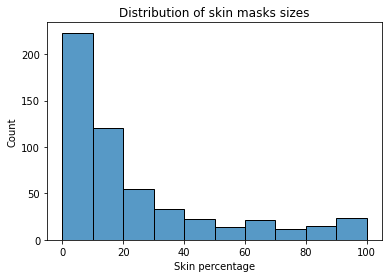

In [45]:
ax = sns.histplot(data=df.skin_detection_percentage, bins=10)
ax.set_title("Distribution of skin masks sizes")
ax.set_xlabel("Skin percentage")

## Filtered images
We will only look at images where the skin was detected 65%> and see how well the appraches worked for these images

In [79]:
df_filtered = df[df.skin_detection_percentage >= 65]

In [80]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 19 to 516
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   hash                             59 non-null     object 
 1   file_path                        59 non-null     object 
 2   image                            59 non-null     object 
 3   ITA_orig                         59 non-null     float64
 4   ITA_center_cropped_all           59 non-null     object 
 5   ITA_center_cropped               59 non-null     float64
 6   ITA_center_cropped_indices       59 non-null     object 
 7   ITA_structured_patches_all       59 non-null     object 
 8   ITA_structured_patches           59 non-null     float64
 9   ITA_structured_patches_indices   59 non-null     object 
 10  ITA_random_patches_20_all        59 non-null     object 
 11  ITA_random_patches_20            59 non-null     float64
 12  ITA_random_patches_20_

## New Distribution

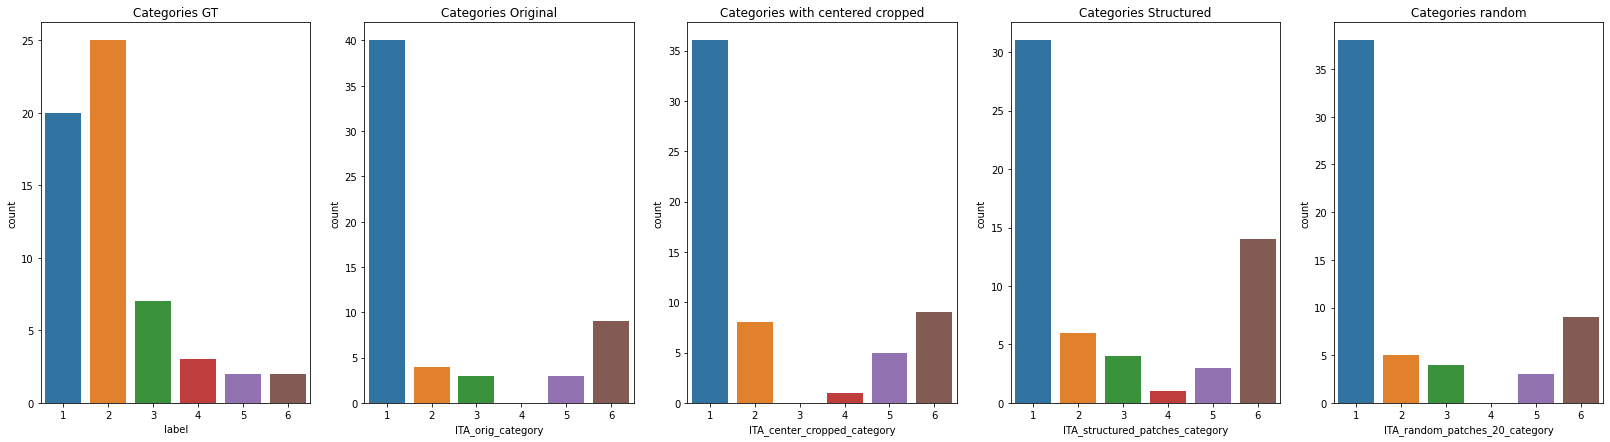

In [81]:
f, axes = plt.subplots(1, 5)
f.set_size_inches(28,7)

ax = sns.countplot(df_filtered.label,ax=axes[0],order=ITA_Categories_list).set_title("Categories GT")
ax = sns.countplot(df_filtered.ITA_orig_category,ax=axes[1],order=ITA_Categories_list).set_title("Categories Original")
ax = sns.countplot(df_filtered.ITA_center_cropped_category,ax=axes[2],order=ITA_Categories_list).set_title("Categories with centered cropped")
ax = sns.countplot(df_filtered.ITA_structured_patches_category,ax=axes[3],order=ITA_Categories_list).set_title("Categories Structured")
ax = sns.countplot(df_filtered.ITA_random_patches_20_category,ax=axes[4],order=ITA_Categories_list).set_title("Categories random")

In [82]:
from sklearn import metrics
for index, cat in enumerate(catagories_to_test):

    category = f"{cat}_category"
    ground_truth = "label"

    #print(category, masked_cat)
    df_temp = df_filtered[df_filtered[category].notna()]
    df_temp = df_temp[df_temp[ground_truth].notna()]
    print(category)
    print(classification_report(df_temp[ground_truth],df_temp[category]))
    print("hamming_loss", hamming_loss(df_temp[ground_truth],df_temp[category]))
    print("---------------")

ITA_orig_category
              precision    recall  f1-score   support

           1       0.42      0.85      0.57        20
           2       0.25      0.04      0.07        25
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2

    accuracy                           0.31        59
   macro avg       0.11      0.15      0.11        59
weighted avg       0.25      0.31      0.22        59

hamming_loss 0.6949152542372882
---------------
ITA_center_cropped_category
              precision    recall  f1-score   support

           1       0.47      0.85      0.61        20
           2       0.62      0.20      0.30        25
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00     

c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: Undefin

<Figure size 504x504 with 0 Axes>

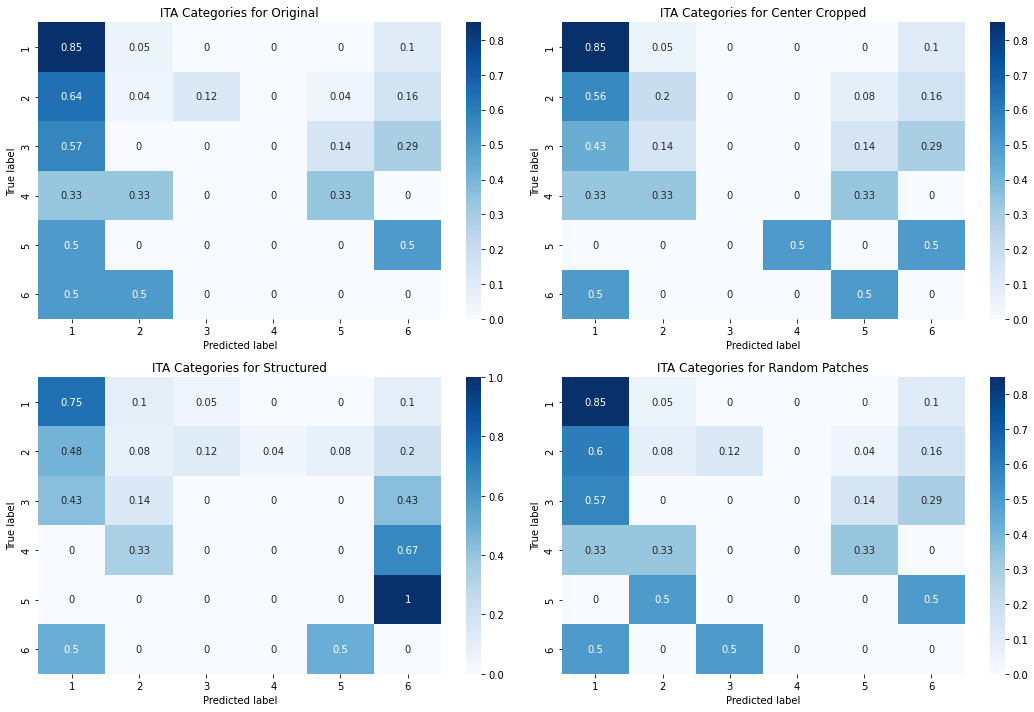

In [83]:
plt.figure(figsize=(7, 7))
cols = 2
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

plot_titles = ["ITA Categories for Original", "ITA Categories for Center Cropped", "ITA Categories for Structured", "ITA Categories for Random Patches",]

for index, cat in enumerate(catagories_to_test):

    category = f"{cat}_category"
    masked_cat = "label"

    #print(category, masked_cat)
    df_temp = df_filtered[df_filtered[category].notna()]
    df_temp = df_temp[df_temp[masked_cat].notna()]
    df_temp = df_temp[df_temp[masked_cat] != "-1"]
    df_temp = df_temp[df_temp[category] != "-1"]


    cm = confusion_matrix(df_temp[masked_cat],df_temp[category],normalize="true")
    df_cm = pd.DataFrame(cm,columns=np.unique(df_temp[masked_cat].to_numpy()),index=np.unique(df_temp[masked_cat].to_numpy()))
    row = index % cols
    col = int(index/cols)
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[col,row])
    ax.set_title(plot_titles[index])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
plt.tight_layout()